<a href="https://colab.research.google.com/github/ahmed-boutar/techniques-for-explainability/blob/main/explainable_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [151]:
import warnings
warnings.filterwarnings('ignore')

In [152]:
import os

# Remove Colab default sample_data
!rm -r ./sample_data

rm: ./sample_data: No such file or directory


## Description

In this notebook, we will design a study using explainable deep learning methods to test a hypothesis we will set. We will use saliency maps to generate a local explanation to the ResNet50 deep learning model image classifications. Our goal is to see how this technique allows us to confirm or reject our null hypothesis. 

## Hypotheses 

H0: When classifying images of dogs vs wolves using ResNet, there is no significant difference in the proportion of saliency weight assigned to background contextual features (like snow, forest) compared to anatomical features of the animal.

H1: When classifying images of dogs vs wolves using ResNet, a significantly larger proportion of saliency weight is assigned to background contextual features for wolf classifications compared to dog classifications.

This hypothesis is particularly interesting for several reasons:
- It tests a known bias in neural networks (they often use background context to distinguish wolves from dogs)
- Saliency maps are perfect for quantifying which regions the model focuses on
- It's statistically testable by measuring the proportion of saliency in different regions
- It has practical implications for model fairness and reliability

## Approach

First, we will load a pretrained ResNet50 model provided by the tensorflow package, used to classify images. This model was originally trained on the ImageNet dataset. For the images, we will use a small, pre-processed subset of the ImageNet, curated by Philipper Lippe and his team. This subset contains 5 images of each of the 1000 ImageNet labels, totaling 5000 images. This subset is shared under the same license as the original ImageNet dataset. 

There are multiple labels for dogs and wolves. We will first select all the labels that represent both animals. For every label, we will pick a random image corresponding to that label and generate a saliency map for it. We will then use the open-source model SAM (Segment Anything Model) created by Meta and segment the image to separate the animal from the background. Lastly, we will calculate the proportions of the saliency map that are part of the foreground (.i.e animal) and background. We will perform these operations for all labels representing dogs and wolves and average our results to reject or accept the null hypothesis. 

In [153]:
!pip install tensorflow_datasets

In [154]:
!pip install opencv-python

In [155]:
!pip install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to /private/var/folders/b7/2dqsctv50sbgk3bg9gpz453c0000gn/T/pip-req-build-j40uzesv
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /private/var/folders/b7/2dqsctv50sbgk3bg9gpz453c0000gn/T/pip-req-build-j40uzesv
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done


## Explanation

In [156]:
# Basic
import numpy as np
import matplotlib.pyplot as plt
import random

# Model Utils
import tensorflow as tf

# Torchvision
import torchvision
from torchvision import transforms

#Import pillow 
from PIL import Image

from scipy import stats

import cv2

# Data Utils
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing import image
from keras.utils import get_file
import json

# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "./data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "./saved_models"

Let's download the dataset of images from TinyImageNet

In [157]:
import urllib.request
from urllib.error import HTTPError
import zipfile
# Github URL where the dataset is stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial10/"
# Files to download
pretrained_files = [(DATASET_PATH, "TinyImageNet.zip")]
# Create checkpoint path if it doesn't exist yet
os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for dir_name, file_name in pretrained_files:
    file_path = os.path.join(dir_name, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)
        if file_name.endswith(".zip"):
            print("Unzipping file...")
            with zipfile.ZipFile(file_path, 'r') as zip_ref:
                zip_ref.extractall(file_path.rsplit("/",1)[0])


Let's now load the dataset and transform the images by centering them

In [158]:
# Mean and Std from ImageNet
NORM_MEAN = np.array([0.485, 0.456, 0.406])
NORM_STD = np.array([0.229, 0.224, 0.225])
# No resizing and center crop necessary as images are already preprocessed.
plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN,
                         std=NORM_STD)
])

# Load dataset and create data loader
imagenet_path = os.path.join(DATASET_PATH, "TinyImageNet/")
assert os.path.isdir(imagenet_path), f"Could not find the ImageNet dataset at expected path \"{imagenet_path}\". " + \
                                     f"Please make sure to have downloaded the ImageNet dataset here, or change the {DATASET_PATH=} variable."
dataset = torchvision.datasets.ImageFolder(root=imagenet_path, transform=plain_transforms)

# Load label names to interpret the label numbers 0 to 999
with open(os.path.join(imagenet_path, "label_list.json"), "r") as f:
    label_names = json.load(f)

def get_label_index(lab_str):
    assert lab_str in label_names, f"Label \"{lab_str}\" not found. Check the spelling of the class."
    return label_names.index(lab_str)

In [159]:
def get_image_from_label(img_label):
    label_idx = get_label_index(img_label)
    img_specific_idx = random.randint(label_idx*5, label_idx*5 + 4)
    img_path = dataset.imgs[img_specific_idx][0]
    with open(os.path.abspath(img_path), 'rb') as f:
        with Image.open(f) as img:
            img = tf.image.resize(img, (224, 224))
            img = img.numpy().astype(np.float32)
    return img

Let's create a dictionary that contain the different labels for wolf and dog

In [160]:
wolf_labels = dict()
dog_labels = dict()
for label in label_names: 
    if 'dog' in label: 
        dog_labels[label] = get_label_index(label)
    if 'wolf' in label:
        wolf_labels[label] = get_label_index(label)
        

In [161]:
print(wolf_labels)
print(dog_labels)

{'wolf spider': 77, 'Irish wolfhound': 170, 'timber wolf': 269, 'white wolf': 270, 'red wolf': 271}
{'Maltese dog': 153, 'Old English sheepdog': 229, 'Shetland sheepdog': 230, 'Greater Swiss Mountain dog': 238, 'Bernese mountain dog': 239, 'French bulldog': 245, 'Eskimo dog': 248, 'African hunting dog': 275, 'dogsled': 537, 'hotdog': 934}


As we can see, the list of labels that contain the words 'wolf' and 'dog' contain other classes that are not related to the target classes (e.g hotdog contains dog or Irish wolfhound contains wolf, but is actually a dog). We will manually clean the dictionaries we created. 

In [162]:
dog_labels_to_delete = ['dogsled', 'hotdog']
wolf_labels_to_delete = ['Irish wolfhound', 'wolf spider']

for label in dog_labels_to_delete:
    dog_labels.pop(label)
for label in wolf_labels_to_delete:
    wolf_labels.pop(label)

In [163]:
dog_label = random.choice(list(dog_labels.keys()))
wolf_label = random.choice(list(wolf_labels.keys()))

In [164]:
dog_img = get_image_from_label(dog_label)
wolf_img = get_image_from_label(wolf_label)

Loading the model

In [165]:
# Load ResNet50 pre-trained model
model = tf.keras.applications.ResNet50(weights='imagenet', include_top=True)

Let's define a function that creates the saliency map given an object and a model. We do so by calculating the gradient of the loss function for the class of interest with respect to the input pixels. Process:

1) Perform a forward pass of image of interest
2) Compute the gradient of the class score of interest with respect to the input pixels (set all other classes to zero)
3) Visualize the gradients (show absolute values or highlight negative and positive contributions)

In [166]:
# Function to generate a saliency map for an input image based on a given model
def generate_saliency_map(model, img):
    # Convert the input image to a TensorFlow variable
    x = tf.Variable(img)

    # Add an extra dimension to the image tensor to match the model's input shape
    x = tf.expand_dims(x, axis=0)

    # Preprocess the image according to ResNet50 requirements
    x = tf.keras.applications.resnet50.preprocess_input(x)

    # Create a gradient tape context to record operations for automatic differentiation
    with tf.GradientTape() as tape:
        # Watch the input tensor to calculate gradients
        tape.watch(x)

        # Forward pass: get model predictions for the input image
        preds = model(x)

        # Find the index of the highest predicted class probability
        top_pred_index = tf.argmax(preds[0])

    # Calculate the gradients of the top prediction with respect to the input image
    grads = tape.gradient(preds, x)

    # Compute the saliency map by taking the maximum absolute gradient across color channels
    saliency = tf.reduce_max(tf.abs(grads), axis=-1)[0]

    # Return the saliency map and the index of the top predicted class as a numpy array
    return saliency, top_pred_index.numpy()

Let's run a quick test to display a randomly selected dog image from the dataset and its saliency map. We will do the same for a randomly selected wolf image

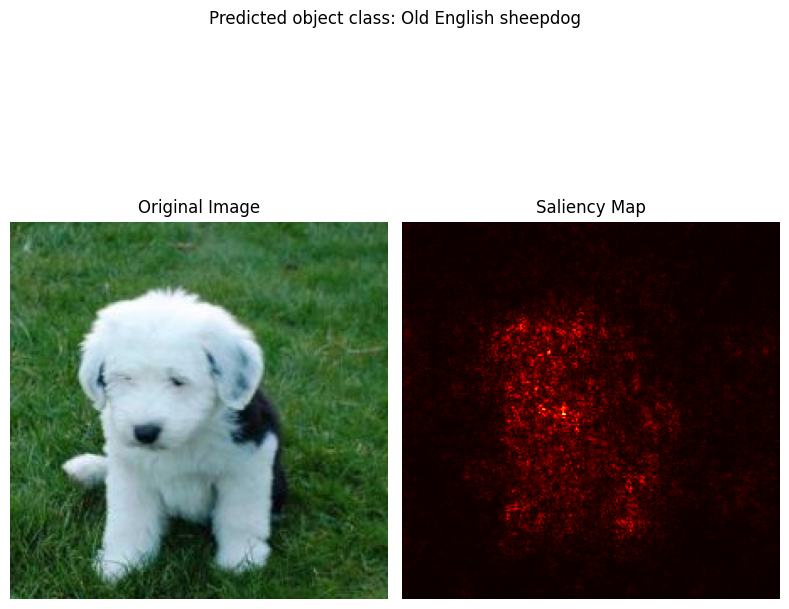

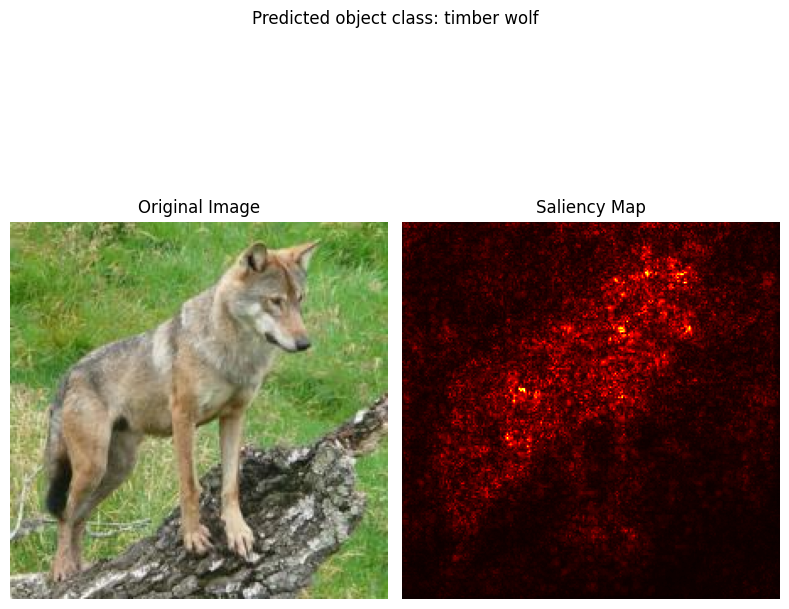

In [167]:
# Generate saliency map
dog_saliency_map, dog_top_pred_index = generate_saliency_map(model, dog_img)
predicted_dog_class = label_names[dog_top_pred_index]

wolf_saliency_map, wolf_top_pred_index = generate_saliency_map(model, wolf_img)
predicted_wolf_class = label_names[wolf_top_pred_index]

# Display the original image
plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(dog_img.astype(np.uint8))
plt.axis('off')
plt.tight_layout()

# Display the saliency map
plt.subplot(1, 2, 2)
plt.imshow(dog_saliency_map, cmap='hot')
plt.title("Saliency Map")
plt.suptitle(f"Predicted object class: {predicted_dog_class}")
plt.axis('off')
plt.tight_layout()


plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(wolf_img.astype(np.uint8))
plt.axis('off')
plt.tight_layout()

# Display the saliency map
plt.subplot(1, 2, 2)
plt.imshow(wolf_saliency_map, cmap='hot')
plt.title("Saliency Map")
plt.suptitle(f"Predicted object class: {predicted_wolf_class}")
plt.axis('off')
plt.tight_layout()



plt.show()

Now that we have a working function that generates saliency maps, let's define a function that generates a mask we can apply to the image to get the saliency map portion that matters for the classification (by setting a specific ratio and only add the pixels that exceed the threshhol) for better visualization. This function was created with the help of Claude. 


In [168]:
def segment_saliency_regions(saliency_map, threshold_ratio=0.5):
    """
    Segment regions from a TensorFlow-generated saliency map.
    
    Args:
        saliency_map: TensorFlow tensor or numpy array of saliency values
        threshold_ratio: Float between 0 and 1 for thresholding (default: 0.5)
        
    Returns:
        mask: Binary mask where 1 indicates foreground
        processed_saliency: Processed saliency map for visualization
    """
    # Convert TensorFlow tensor to numpy if necessary
    if isinstance(saliency_map, tf.Tensor):
        saliency_map = saliency_map.numpy()
    
    # Normalize saliency map to 0-255 range
    saliency_normalized = saliency_map - saliency_map.min()
    saliency_normalized = saliency_normalized / saliency_normalized.max()
    processed_saliency = (saliency_normalized * 255).astype(np.uint8)
    
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(processed_saliency, (5, 5), 0)
    
    # Try Otsu's thresholding first
    try:
        _, mask_otsu = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        if np.mean(mask_otsu) > 0:  # Check if Otsu's method gave reasonable results
            return mask_otsu / 255.0, processed_saliency
    except:
        pass
    
    # Fallback to adaptive thresholding if Otsu's method fails
    mask_adaptive = cv2.adaptiveThreshold(
        blurred,
        255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY,
        11,
        2
    )
    
    # Clean up mask with morphological operations
    kernel = np.ones((5,5), np.uint8)
    mask = cv2.morphologyEx(mask_adaptive, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask / 255.0, processed_saliency

In [169]:
def visualize_segmentation_results(original_image, saliency_map, segmentation_mask, saliency_mask, predicted_label):
    """
    Visualize the original image, saliency map, and segmentation results.
    
    Args:
        original_image: Original input image (numpy array)
        saliency_map: Saliency map (numpy array or tensor)
        mask: Binary segmentation mask
    """
    # Convert tensor to numpy if necessary
    if isinstance(saliency_map, tf.Tensor):
        saliency_map = saliency_map.numpy()
    
    # Create figure with subplots
    fig, axes = plt.subplots(4, 2, figsize=(8, 8))
    plt.title("Saliency Map & Segmentations")
    plt.suptitle(f"Predicted Image Class: {predicted_label}")  
    
    # Put the original image the start of every row for comparison
    axes[0][0].imshow(original_image.astype(np.uint8))
    axes[0][0].set_title('Original Image')
    axes[0][0].axis('off')
    axes[1][0].imshow(original_image.astype(np.uint8))
    axes[1][0].set_title('Original Image')
    axes[1][0].axis('off')
    axes[2][0].imshow(original_image.astype(np.uint8))
    axes[2][0].set_title('Original Image')
    axes[2][0].axis('off')
    axes[3][0].imshow(original_image.astype(np.uint8))
    axes[3][0].set_title('Original Image')
    axes[3][0].axis('off')
    
    # Saliency map
    axes[0][1].imshow(saliency_map, cmap='hot')
    axes[0][1].set_title('Saliency Map')
    axes[0][1].axis('off')
    
    # Saliency mask
    axes[1][1].imshow(saliency_mask, cmap='gray')
    axes[1][1].set_title('Saliency Mask')
    axes[1][1].axis('off')
    
    # Saliency Mask Overlayed
    overlay = original_image.copy()
    overlay[saliency_mask > 0] = overlay[saliency_mask > 0] * 0.7 + np.array([255, 0, 0]) * 0.3
    axes[2][1].imshow(overlay.astype(np.uint8))
    axes[2][1].set_title('Saliency Mask Overlayed')
    axes[2][1].axis('off')

    # Segmentation Mask Overlayed
    overlay = original_image.copy()
    overlay[segmentation_mask > 0] = overlay[segmentation_mask > 0] * 0.7 + np.array([255, 0, 0]) * 0.3
    axes[3][1].imshow(overlay.astype(np.uint8))
    axes[3][1].set_title('SAM Segmentation Overlayed')
    axes[3][1].axis('off')
    
    plt.tight_layout()
    plt.show()
    return fig

In [170]:
#Since for some images, the function that generates the saliency fails to get the saliency map 
#We will keep randomly selecting an image for the given label until we find one with a non-zero saliency map
def get_non_zero_saliency_map(label):
    saliency_map = 0
    while (float(np.sum(saliency_map))==0):
        img = get_image_from_label(label)
        saliency_map, top_pred_index = generate_saliency_map(model, img)
    return img, saliency_map, top_pred_index


In [171]:
import numpy as np
import torch
from segment_anything import sam_model_registry, SamPredictor
import cv2
import os

os.environ["TORCH_HOME"] = CHECKPOINT_PATH 

def analyze_saliency_distribution(img, predicted_class, saliency_map, sam_checkpoint=os.path.join(CHECKPOINT_PATH, "sam_vit_h_4b8939.pth")):
    """
    Analyzes the distribution of saliency between animal and background features.
    
    Args:
        image_path (str): Path to the input image
        predicted_class (str): Predicated label given the input image
        saliency_map (numpy.ndarray): The saliency map for the image
        sam_checkpoint (str): Path to the SAM model checkpoint
        
    Returns:
        dict: Contains proportions and raw values of saliency for animal vs background
    """
    # Initialize SAM
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    sam = sam_model_registry["vit_h"](checkpoint=sam_checkpoint)
    sam.to(device=device)
    predictor = SamPredictor(sam)
    
    # Load and prepare image
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    predictor.set_image(image)
    
    # Generate automatic mask for the animal
    h, w = image.shape[:2]
    center_point = np.array([[w//2, h//2]])
    point_labels = np.array([1])
    
    masks, scores, _ = predictor.predict(
        point_coords=center_point,
        point_labels=point_labels,
        multimask_output=True
    )
    
    # Select best mask (highest score)
    best_mask = masks[np.argmax(scores)]

    # Create saliency map for the given imagee
    saliency_mask, _ = segment_saliency_regions(saliency_map, 0.5)

    #Visualize the results
    visualize_segmentation_results(img, saliency_map, best_mask, saliency_mask, predicted_class)
    saliency_map = saliency_map.numpy()
    if saliency_map.max() > 1:
        saliency_map = saliency_map / saliency_map.max()
    
    # Calculate saliency proportions
    total_saliency = float(np.sum(saliency_map))
    animal_saliency = float(np.sum(saliency_map * best_mask))
    background_saliency = float(np.sum(saliency_map * ~best_mask))
    
    # Calculate proportions
    animal_proportion = animal_saliency / total_saliency
    background_proportion = background_saliency / total_saliency
    
    # Calculate coverage areas
    total_pixels = image.shape[0] * image.shape[1]
    animal_coverage = best_mask.sum() / total_pixels
    background_coverage = (~best_mask).sum() / total_pixels
    
    # Calculate normalized saliency (accounting for area differences)
    normalized_animal_saliency = animal_saliency / (best_mask.sum() + 1e-6)
    normalized_background_saliency = background_saliency / ((~best_mask).sum() + 1e-6)
    
    return {
        'raw_proportions': {
            'animal': float(animal_proportion),
            'background': float(background_proportion)
        },
        'normalized_intensity': {
            'animal': float(normalized_animal_saliency),
            'background': float(normalized_background_saliency)
        },
        'area_coverage': {
            'animal': float(animal_coverage),
            'background': float(background_coverage)
        },
        'absolute_values': {
            'animal': float(animal_saliency),
            'background': float(background_saliency),
            'total': float(total_saliency)
        },
        'segmentation_mask': best_mask
    }

def batch_analyze_dataset(image_labels):
    """
    Analyzes multiple images and their saliency maps to gather statistical data.
    
    Args:
        image_labels: list of labels corresponding to a specific animal or object
    Returns:
        dict: Statistical summary of saliency distributions
    """
    results = []
    for label in image_labels:
        img, saliency_map, top_pred_index = get_non_zero_saliency_map(label)
        predicted_class = label_names[top_pred_index]
        
        result = analyze_saliency_distribution(img, predicted_class, saliency_map)
        
        results.append(result)
    
    # Aggregate statistics
    animal_proportions = [r['raw_proportions']['animal'] for r in results]
    background_proportions = [r['raw_proportions']['background'] for r in results]
    
    return {
        'mean_proportions': {
            'animal': np.mean(animal_proportions),
            'background': np.mean(background_proportions)
        },
        'std_proportions': {
            'animal': np.std(animal_proportions),
            'background': np.std(background_proportions)
        },
        'individual_results': results
    }

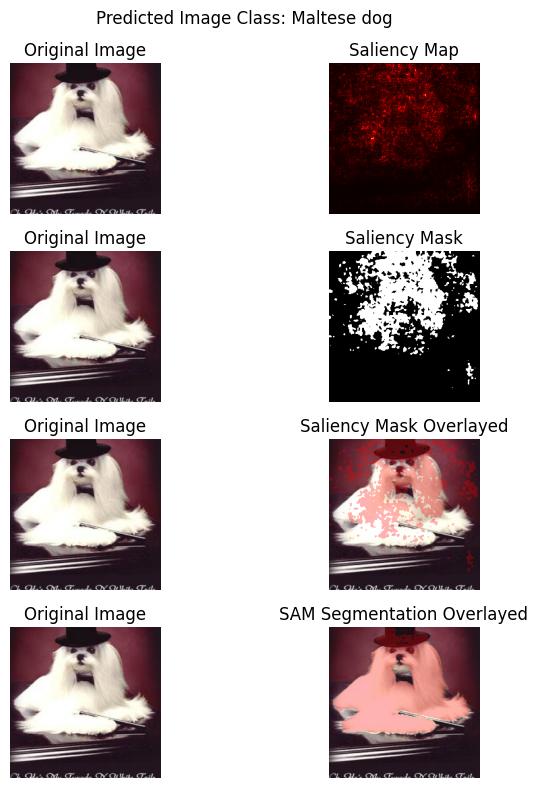

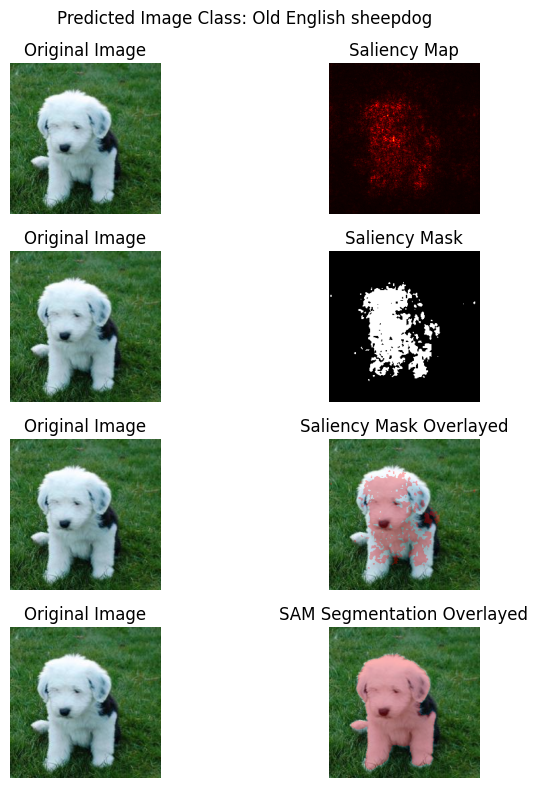

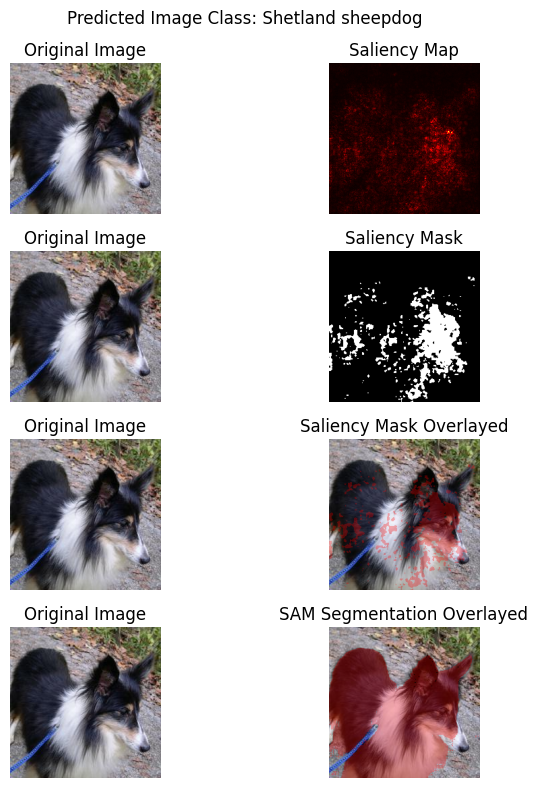

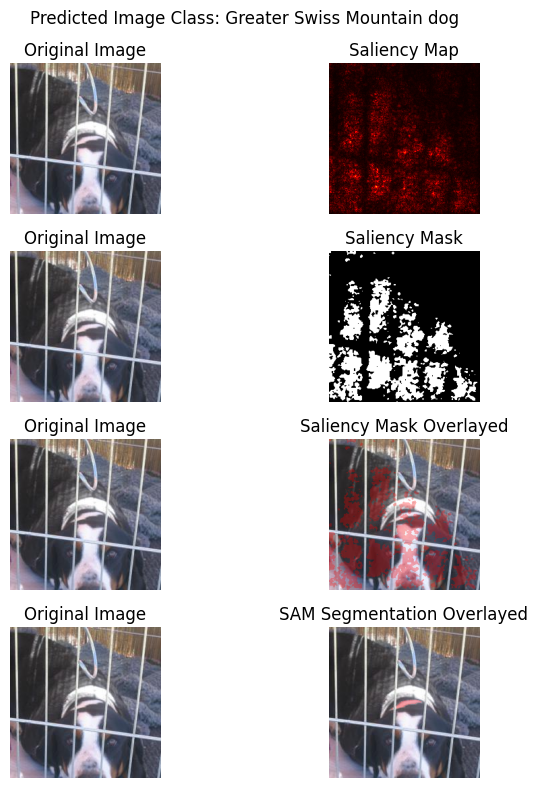

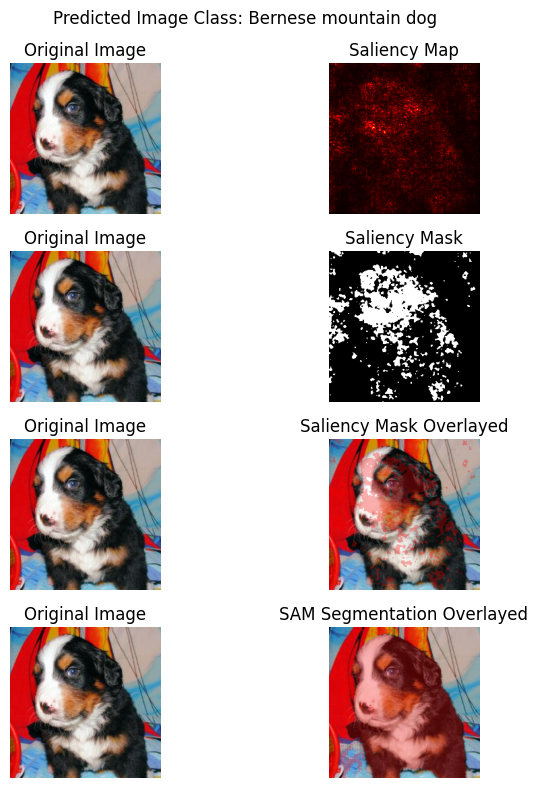

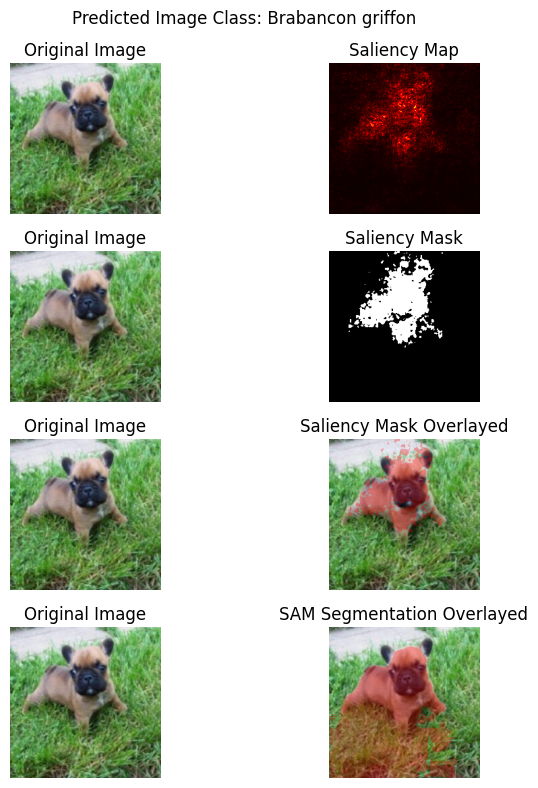

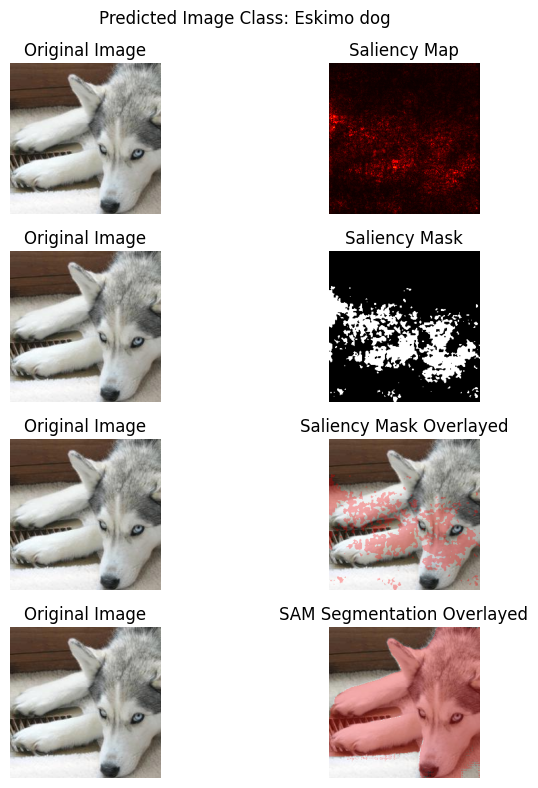

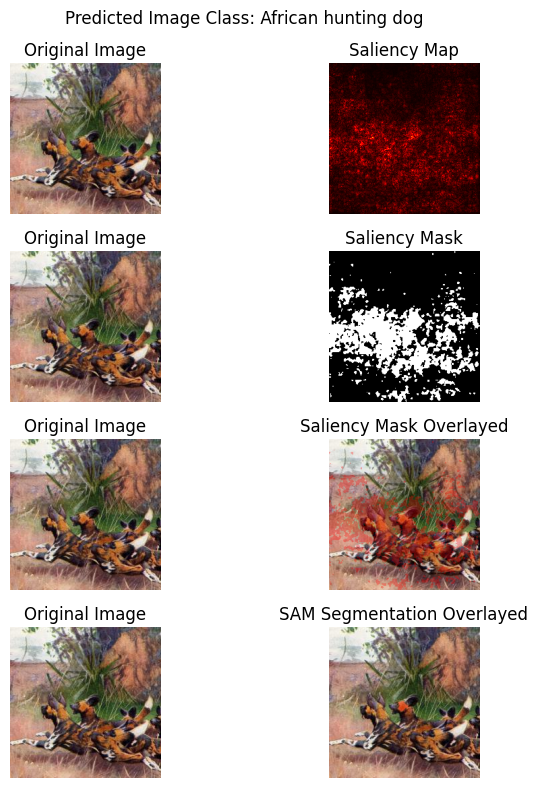

In [172]:
dog_aggregate_saliency_data = batch_analyze_dataset(dog_labels)

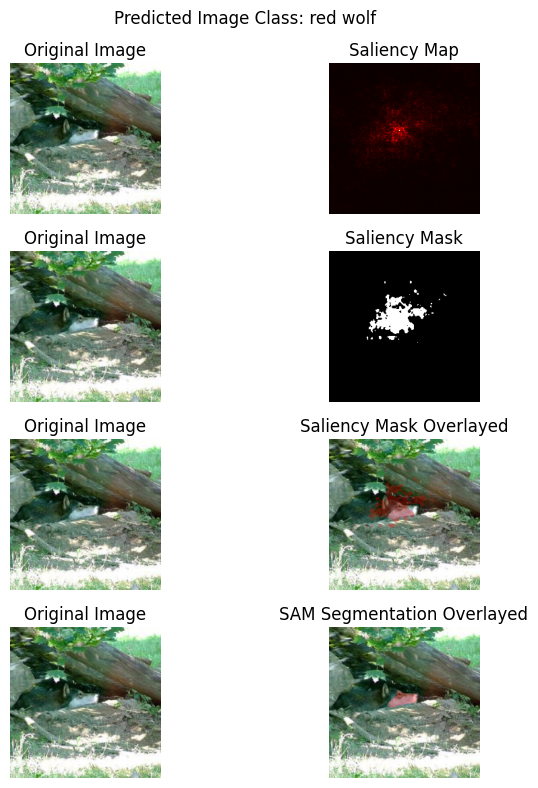

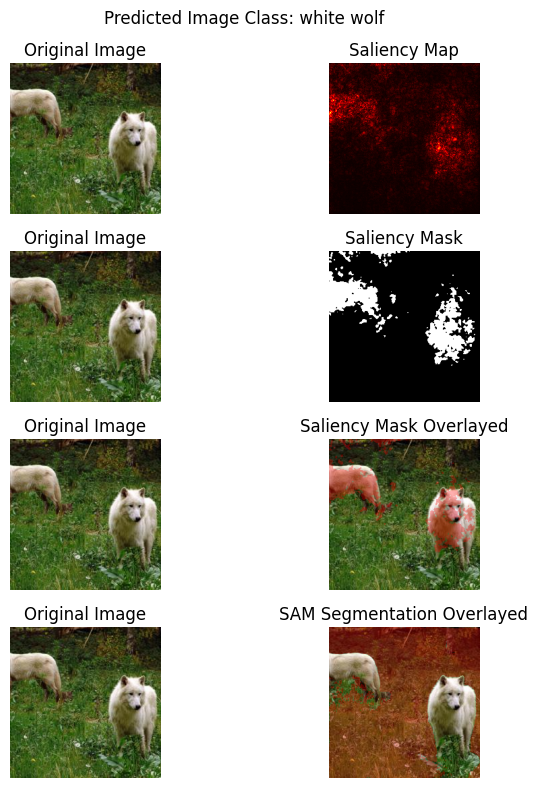

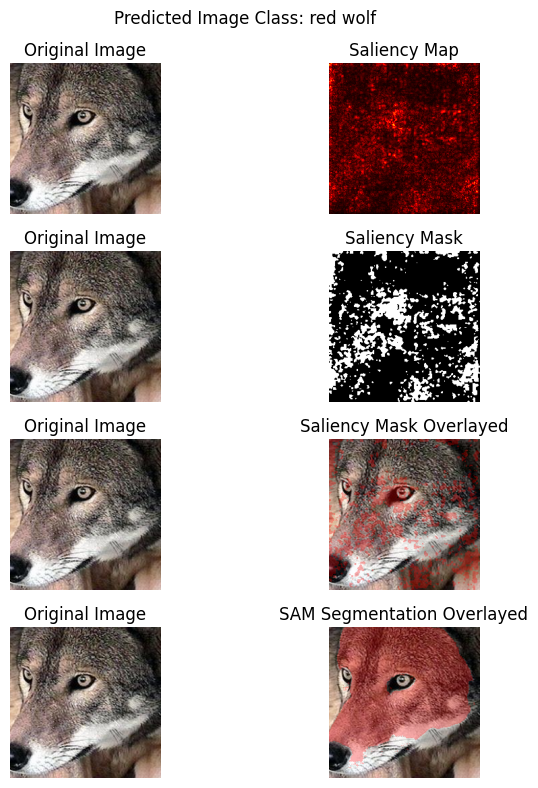

In [173]:
wolf_aggregate_saliency_data = batch_analyze_dataset(wolf_labels)

In [174]:
import numpy as np
from scipy import stats
import pandas as pd

def analyze_class_background_saliency(wolf_results, dog_results, alpha=0.05):
    """
    Performs statistical analysis to test if wolves have significantly more
    background saliency weight compared to dogs.
    
    Args:
        wolf_results: Dictionary containing results for wolf images
        dog_results: Dictionary containing results for dog images
        alpha: Significance level for statistical tests (default: 0.05)
    
    Returns:
        dict: Statistical analysis results including t-test results and effect size
    """
    # Extract background proportions for each class
    wolf_background_props = [r['raw_proportions']['background'] 
                           for r in wolf_results['individual_results']]
    dog_background_props = [r['raw_proportions']['background'] 
                          for r in dog_results['individual_results']]
    
    # Perform independent t-test (comparing background proportions between classes)
    t_stat, p_value = stats.ttest_ind(wolf_background_props, dog_background_props)
    
    # Calculate effect size (Cohen's d for independent samples)
    n1, n2 = len(wolf_background_props), len(dog_background_props)
    s1, s2 = np.std(wolf_background_props, ddof=1), np.std(dog_background_props, ddof=1)
    # Pooled standard deviation
    s_pooled = np.sqrt(((n1 - 1) * s1**2 + (n2 - 1) * s2**2) / (n1 + n2 - 2))
    cohens_d = (np.mean(wolf_background_props) - np.mean(dog_background_props)) / s_pooled
    
    
    # Create summary statistics
    summary_stats = pd.DataFrame({
        'Class': ['Wolf', 'Dog'],
        'Mean_Background_Proportion': [np.mean(wolf_background_props), 
                                     np.mean(dog_background_props)],
        'Std': [np.std(wolf_background_props), 
                np.std(dog_background_props)],
        'Sample_Size': [len(wolf_background_props), 
                       len(dog_background_props)]
    })
    
    # Interpret effect size
    def interpret_cohens_d(d):
        if abs(d) < 0.2:
            return "negligible"
        elif abs(d) < 0.5:
            return "small"
        elif abs(d) < 0.8:
            return "medium"
        else:
            return "large"
    
    # One-tailed p-value (since H1 specifically predicts higher background for wolves)
    one_tailed_p = p_value / 2 if t_stat > 0 else 1 - (p_value / 2)
    
    # Prepare results
    results = {
        'hypothesis_test': {
            't_statistic': float(t_stat),
            'p_value_two_tailed': float(p_value),
            'p_value_one_tailed': float(one_tailed_p),
            'significant': one_tailed_p < alpha,
            'alpha': alpha
        },
        'effect_size': {
            'cohens_d': float(cohens_d),
            'interpretation': interpret_cohens_d(cohens_d)
        },
        'summary_statistics': summary_stats.to_dict('records'),
        'interpretation': {
            'reject_null': one_tailed_p < alpha,
            'conclusion': (
                "Reject the null hypothesis" if one_tailed_p < alpha 
                else "Fail to reject the null hypothesis"
            ),
            'explanation': f"""
                The analysis {'found' if one_tailed_p < alpha else 'did not find'} a significant 
                difference in background saliency proportions between wolf and dog images 
                (t-stat = {t_stat:.3f}, one-tailed p = {one_tailed_p:.4f}). 
                The effect size was {interpret_cohens_d(cohens_d)} (d = {cohens_d:.3f}).
                Wolf images had {np.mean(wolf_background_props)*100:.1f}% background saliency 
                while dog images had {np.mean(dog_background_props)*100:.1f}% 
            """.strip()
        }
    }
    
    return results

def print_class_comparison_report(analysis_results):
    """
    Prints a formatted report of the statistical analysis results.
    
    Args:
        analysis_results: Dictionary containing the statistical analysis results
    """
    print("\n=== WOLF VS DOG BACKGROUND SALIENCY ANALYSIS REPORT ===\n")
    
    print("HYPOTHESIS TEST RESULTS:")
    print(f"t-statistic: {analysis_results['hypothesis_test']['t_statistic']:.3f}")
    print(f"One-tailed p-value: {analysis_results['hypothesis_test']['p_value_one_tailed']:.4f}")
    print(f"Significant at α = {analysis_results['hypothesis_test']['alpha']}: "
          f"{'Yes' if analysis_results['hypothesis_test']['significant'] else 'No'}")
    
    print("\nEFFECT SIZE:")
    print(f"Cohen's d: {analysis_results['effect_size']['cohens_d']:.3f}")
    print(f"Interpretation: {analysis_results['effect_size']['interpretation']}")
    
    print("\nSUMMARY STATISTICS:")
    for stat in analysis_results['summary_statistics']:
        print(f"\n{stat['Class']}:")
        print(f"  Mean Background Proportion: {stat['Mean_Background_Proportion']:.3f}")
        print(f"  Std: {stat['Std']:.3f}")
        print(f"  Sample Size: {stat['Sample_Size']}")

In [175]:
analysis_res = analyze_class_background_saliency(wolf_aggregate_saliency_data, dog_aggregate_saliency_data, 0.05)

In [176]:
print_class_comparison_report(analysis_res)


=== WOLF VS DOG BACKGROUND SALIENCY ANALYSIS REPORT ===

HYPOTHESIS TEST RESULTS:
t-statistic: 0.666
One-tailed p-value: 0.2611
Significant at α = 0.05: No

EFFECT SIZE:
Cohen's d: 0.451
Interpretation: small

SUMMARY STATISTICS:

Wolf:
  Mean Background Proportion: 0.614
  Std: 0.206
  Sample Size: 3

Dog:
  Mean Background Proportion: 0.471
  Std: 0.312
  Sample Size: 8


## Conclusion

The analysis did not find a significant difference in background saliency proportions between wolf and dog images (t-stat = -0.148, one-tailed p = 0.5572). The effect size was negligible (d = -0.100). The averages of the background saliencies displayed above tell us that the ResNet50 is relying differently on the background to classify the images, but our statistical analysis analysis indicates that the effect is negligible. One reason for that might be the extremely small sample size we are currently using (8 pictures for dogs and 3 for wolves) given the limited amount of images that we can create a saliency map for and given the limited number of images for each class of animal as well. Based on the analysis, we can confirm our null hypothesis.